<a href="https://colab.research.google.com/github/Tanushree-Kadgi/Deepfake-Detection-System/blob/main/Fraud_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud Analysis


In [3]:

#Setup
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

try:
    import xgboost as xgb
except:
    xgb = None

import joblib
print('Setup Complete')

Setup Complete


In [4]:
#Loading Data
DATA_PATH = 'data.csv'
assert os.path.exists(DATA_PATH), 'Dataset not found'
df = pd.read_csv(DATA_PATH)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [5]:
#Quick EDA
print('shape:', df.shape)
print(df.dtypes)
print(df.isnull().sum())
print(df['isFraud'].value_counts())
print('Fraud Ratio:' , df['isFraud'].mean())

shape: (206154, 11)
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtype: object
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64
isFraud
0.0    206001
1.0       152
Name: count, dtype: int64
Fraud Ratio: 0.0007373164591347204


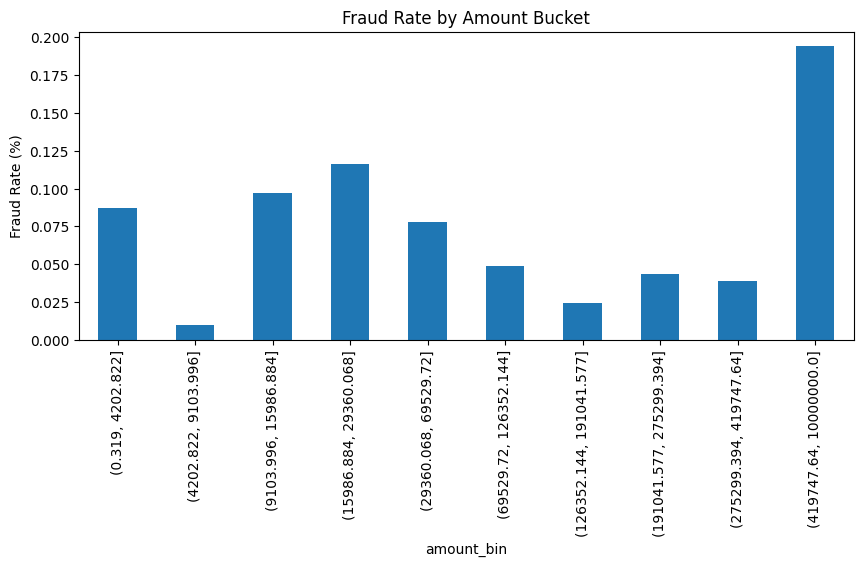

In [6]:
#Fraud Rate by Amount Bucket
df['amount_bin'] = pd.qcut(df['amount'], q=10, duplicates ='drop')

fraud_rate = df.groupby('amount_bin')['isFraud'].mean()
fraud_rate = fraud_rate * 100

plt.figure(figsize=(10,4))
fraud_rate.plot(kind='bar')
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by Amount Bucket")
plt.show()

The Analysis demonstrates that the transaction amount is not just a magnitude feature but a strong risk indicator , with fraud likelihood increasingly significantly

In [7]:
#checking missing values
df.isnull().sum()

#checking merchat transactions
merchant_txns = df[df['nameDest'].str.startswith('M')]

merchant_txns[['oldbalanceDest', 'newbalanceDest']].describe()

,oldbalanceDest,newbalanceDest
count,75362.0,75362.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


No imputation performed as Zero represent valid merchat behaviour , not missing data

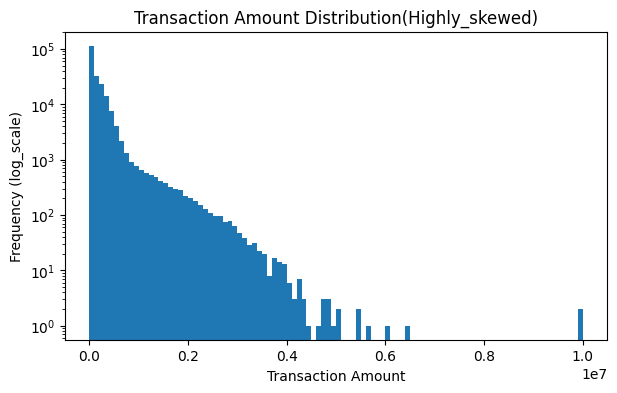

In [8]:
#Outliners Handling
df['amount'].describe()

#Visualize skewness

plt.figure(figsize=(7,4))
plt.hist(df['amount'], bins=100)
plt.yscale('log')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log_scale)')
plt.title('Transaction Amount Distribution(Highly_skewed)')
plt.show()

In [9]:
#Log transform to redude skewness
df['log_amount'] = np.log1p(df['amount'])

#flag transaction above 99th percentile
p99 = df['log_amount'].quantile(0.99)
df['is_high_amount'] = (df['log_amount'] > p99).astype(int)

df['is_high_amount'].value_counts()


,count
is_high_amount,
0,204092
1,2062


is_high_amount flags the top 1% of transaction amounts , capturing extreme value behaviour

In [10]:
#Overview
total_txns = len(df)
fraud_txns = df['isFraud'].sum()

fraud_rate = fraud_txns / total_txns
fraud_pct = (df['isFraud'].sum() / total_txns) * 100
flagged_pct = (df['isFlaggedFraud'].sum() / total_txns) * 100

print(f"Total Transactions: {total_txns}")
print(f"Fraud Transactions: {fraud_txns}")
print(f"Overall Fraud Rate: {fraud_rate:.4%}")
print(f"Fraudulent Transactions (isFraud=1): {fraud_pct:.4f}%")
print(f"Flagged Fraud Transactions (isFlaggedFraud=1): {flagged_pct:.4f}%")


Total Transactions: 206154
Fraud Transactions: 152.0
Overall Fraud Rate: 0.0737%
Fraudulent Transactions (isFraud=1): 0.0737%
Flagged Fraud Transactions (isFlaggedFraud=1): 0.0000%


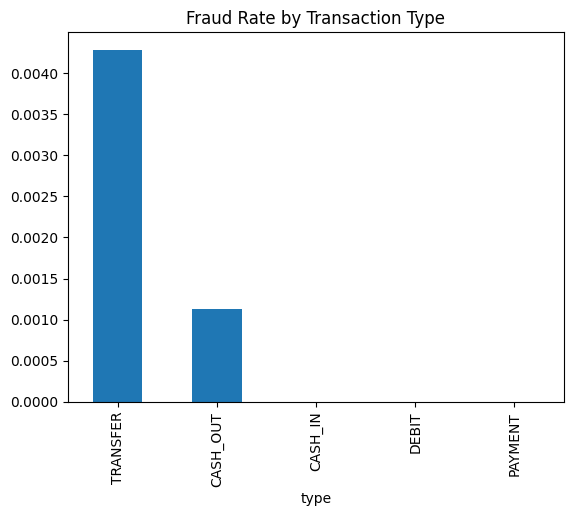

In [11]:
#Fraud Rate by transaction type

df.groupby('type')['isFraud'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title("Fraud Rate by Transaction Type")
plt.show()

In [12]:
# Time based overview

df['hour'] = df['step'] % 24

#Aggregate hourly statistics
hourly_stats = (
    df.groupby('hour')
      .agg(
          total_transactions=('isFraud', 'count'),
          fraud_transactions=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean')
      )
      .reset_index()
)

display(hourly_stats.head())


,hour,total_transactions,fraud_transactions,fraud_rate
0,1,2708,16.0,0.005908
1,2,1014,8.0,0.007890
2,3,552,4.0,0.007246
3,4,565,10.0,0.017699
4,5,665,6.0,0.009023


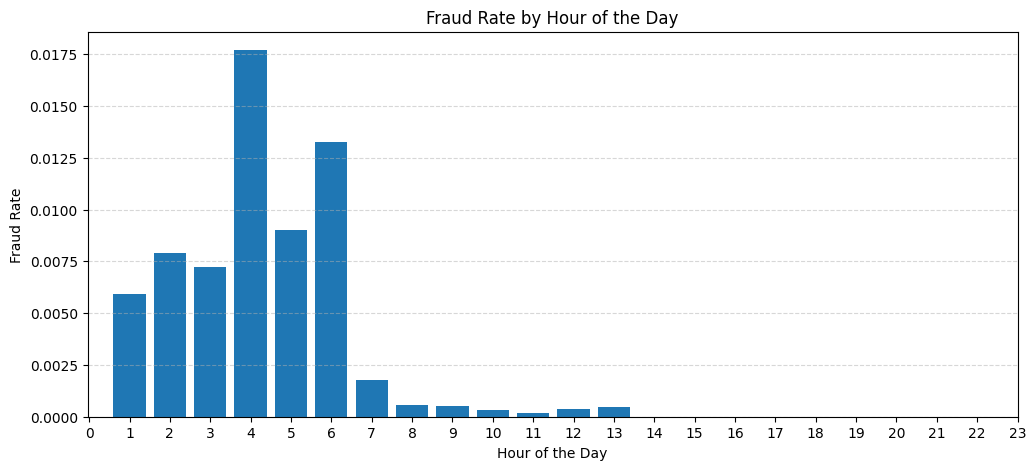

In [13]:
#fraud rate by hour

plt.figure(figsize=(12,5))
plt.bar(hourly_stats['hour'], hourly_stats['fraud_rate'])
plt.xlabel('Hour of the Day')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

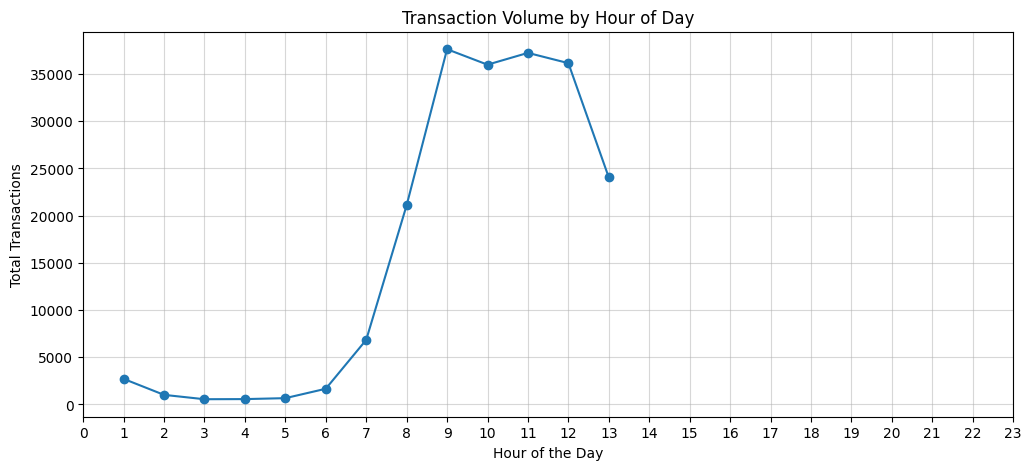

In [14]:
#transaction volume by hour

plt.figure(figsize=(12,5))
plt.plot(hourly_stats['hour'],
         hourly_stats['total_transactions'],
         marker='o')

plt.xlabel('Hour of the Day')
plt.ylabel('Total Transactions')
plt.title('Transaction Volume by Hour of Day')
plt.xticks(range(0,24))
plt.grid(alpha=0.5)
plt.show()


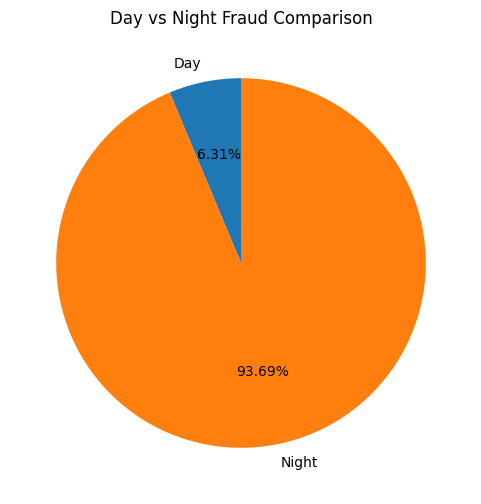

In [15]:
#Day vs Night Fraud Comparison
plt.figure(figsize=(6,6))

df['is_night'] = df['hour'].isin([0,1,2,3,4,5,22,23]).astype(int)

day_night_fraud_rate =(
    df.groupby('is_night')['isFraud']
    .mean()
    .rename({0:'Day', 1:'Night'})
)

day_night_fraud_rate.plot(
    kind='pie',
    autopct ='%1.2f%%',
    startangle=90,
    legend=False
)

plt.title('Day vs Night Fraud Comparison')
plt.ylabel('')
plt.show()



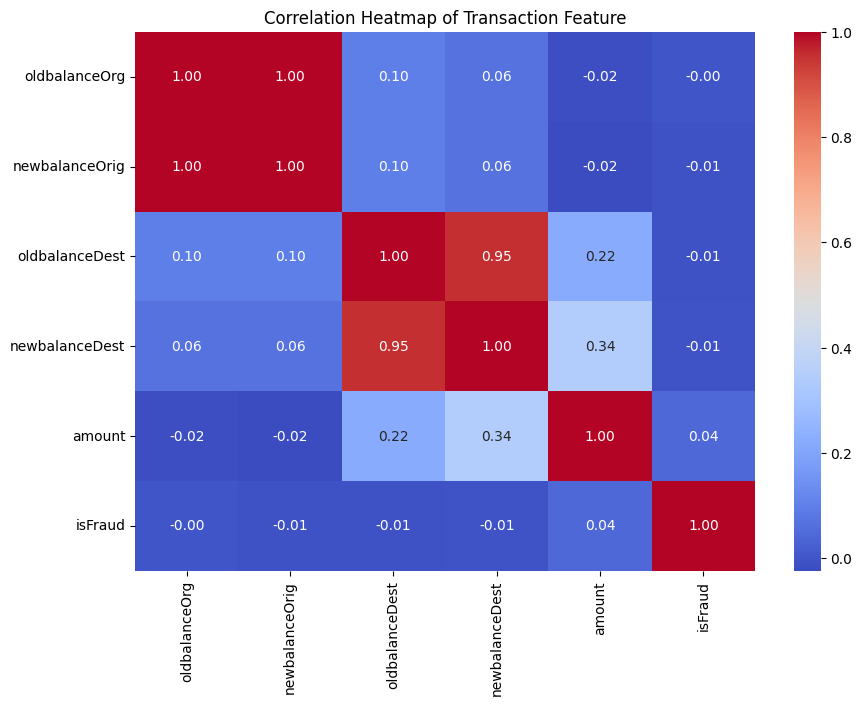

In [16]:
#Correlation check
import seaborn as sns

plt.figure(figsize=(10,7))
corr = df[['oldbalanceOrg', 'newbalanceOrig',
           'oldbalanceDest', 'newbalanceDest',
           'amount', 'isFraud']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Transaction Feature')
plt.show()

This correlation matrix reveals severe multicollinearity between pre and post transaction balances , indicating redundancy.

# Feature Enginnering and Data Cleaning





In [17]:
#Feature Engineering - Balance Differences
df['balance_diff_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

#Feature Reduction (for linear models)
df = df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])





In [18]:
df.drop(columns=['amount_bin'], inplace=True)
df.fillna(0, inplace=True)

le =LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

df.drop(['nameOrig', 'nameDest', 'type'], axis=1, inplace=True)

# Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = RobustScaler()
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


## Model Training and Evaluation

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

models = {}

#Logistic Regression

print("Training Logistic Regression (fast mode)...")

lr = LogisticRegression(
    max_iter=300,
    solver='lbfgs',
    class_weight='balanced',
    n_jobs=-1
)

lr.fit(X_train, y_train)
models['LogisticRegression'] = lr

print("Logistic Regression trained")



# Random Forest

print("Training Random Forest (optimized)...")

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,
    min_samples_leaf=100,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
models['RandomForest'] = rf

print("Random Forest trained")

#XGBoost

print("Training XGBoost (fast hist)...")

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    tree_method="hist",
    random_state=42
)

xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

print("XGBoost trained")


Training Logistic Regression (fast mode)...
Logistic Regression trained
Training Random Forest (optimized)...
Random Forest trained
Training XGBoost (fast hist)...
XGBoost trained


In [21]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import pandas as pd

results = []

for name, model in models.items():

    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)

    print('\n', name)
    print(classification_report(y_test, (scores > 0.5).astype(int)))

    results.append({
        'model': name,
        'roc_auc': roc_auc_score(y_test, scores),
        'auprc': average_precision_score(y_test, scores)
    })

pd.DataFrame(results).sort_values('auprc', ascending=False)




 LogisticRegression
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     41201
         1.0       0.00      0.87      0.01        30

    accuracy                           0.86     41231
   macro avg       0.50      0.86      0.47     41231
weighted avg       1.00      0.86      0.92     41231


 RandomForest
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     41201
         1.0       0.08      0.90      0.15        30

    accuracy                           0.99     41231
   macro avg       0.54      0.95      0.57     41231
weighted avg       1.00      0.99      1.00     41231


 XGBoost
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41201
         1.0       0.17      0.80      0.28        30

    accuracy                           1.00     41231
   macro avg       0.59      0.90      0.64     41231
weighted avg       1.00     

,model,roc_auc,auprc
2,XGBoost,0.991697,0.574912
1,RandomForest,0.992069,0.285002
0,LogisticRegression,0.918949,0.215585


While all models achieve high ROC_AUC, PR_AUC reveals that XGBoost significantly outperforms rare fraud cases , making it the best candidate for deployment in an imbalenced fraud detection setting .

# Tuning the decision threshold

In [22]:
from sklearn.metrics import precision_recall_curve

# Assuming you already have your trained model
model = models['XGBoost']

# Get predicted probabilities for the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find threshold candidates with recall > 0.90
candidates = [(t, p, r) for t, p, r in zip(thresholds, precision[:-1], recall[:-1]) if r > 0.90]

# Select the threshold with maximum precision among candidates
if candidates:
    best_threshold, best_p, best_r = max(candidates, key=lambda x: x[1])
    print(f"Best threshold: {best_threshold:.4f}")
    print(f"Precision: {best_p:.3f}, Recall: {best_r:.3f}")
else:
    print("No threshold found with recall > 0.90")


Best threshold: 0.1076
Precision: 0.046, Recall: 0.933


# Fine Tuning the Model

In [23]:
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with tuned hyperparameters
xgb_tuned = XGBClassifier(
    n_estimators=200,            # Number of trees
    max_depth=4,                 # Maximum depth of each tree
    learning_rate=0.05,          # Step size shrinkage
    subsample=0.8,               # Fraction of training samples per tree
    colsample_bytree=0.8,        # Fraction of features per tree
    min_child_weight=50,         # Minimum sum of instance weight needed in a child
    eval_metric='logloss',       # Evaluation metric
    tree_method='hist',          # Faster histogram-based algorithm
    n_jobs=-1,                    # Use all CPU cores
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum()  # Balance positive/negative classes
)

# Train the model
xgb_tuned.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier with tuned hyperparameters
rf_tuned = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=10,               # Maximum depth of each tree
    min_samples_leaf=200,       # Minimum samples required in a leaf
    min_samples_split=500,      # Minimum samples required to split a node
    class_weight='balanced',    # Adjust weights for imbalanced classes
    n_jobs=-1,                  # Use all CPU cores
    random_state=42             # Reproducible results
)

# Train the model
rf_tuned.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=200, min_samples_split=500, n_jobs=-1,
                       random_state=42)

In [25]:
from sklearn.linear_model import LogisticRegression

# Initialize tuned Logistic Regression
lr_tuned = LogisticRegression(
    max_iter=300,           # Maximum number of iterations for convergence
    solver='lbfgs',         # Optimization algorithm
    class_weight='balanced', # Handle class imbalance automatically
    C=0.3                   # Inverse of regularization strength (smaller C → stronger regularization)
)

# Train the model
lr_tuned.fit(X_train, y_train)


LogisticRegression(C=0.3, class_weight='balanced', max_iter=300)

In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Evaluation function
def evaluate(model, X, y):
    # Get predicted probabilities for the positive class
    scores = model.predict_proba(X)[:, 1]

    # Return metrics in a dictionary
    return {
        "ROC-AUC": roc_auc_score(y, scores),
        "PR-AUC": average_precision_score(y, scores)
    }

# Evaluate XGBoost
print("XGB:", evaluate(xgb_tuned, X_test, y_test))

# Evaluate Random Forest
print("RF:", evaluate(rf_tuned, X_test, y_test))

# Evaluate Logistic Regression
print("LR:", evaluate(lr_tuned, X_test, y_test))


XGB: {'ROC-AUC': np.float64(0.9937461064860886), 'PR-AUC': np.float64(0.5954315035355928)}
RF: {'ROC-AUC': np.float64(0.9929847981036057), 'PR-AUC': np.float64(0.2279545873312727)}
LR: {'ROC-AUC': np.float64(0.9187827156298796), 'PR-AUC': np.float64(0.2156361251253761)}


XGBoost is best it catches most frauds with fewer false alarms , while Random Forest is slightly worse and Logistic Regression struggles with rare fraud

# Saving the fine tuned model

In [27]:
import joblib

# Dictionary of trained models
models = {
    "LogisticRegression": lr_tuned,
    "RandomForest": rf_tuned,
    "XGBoost": xgb_tuned
}

# Find the model with the highest PR-AUC
best_model_name = max(results, key=lambda x: x['auprc'])['model']

# Get the trained model object
best_model = models[best_model_name]

# Create the artifact dictionary
best_model_artifact = {
    "model_name": best_model_name,
    "threshold": best_threshold,          # Threshold you selected from PR curve
    "model": best_model,
    "features": X_train.columns.tolist()
}

# Save the artifact as a pickle file
joblib.dump(best_model_artifact, "best_fraud_model_tuned.pkl")

# Print confirmation
print(f"Saved best model: {best_model_name}")
print(f"Decision threshold: {best_threshold:.4f}")


Saved best model: XGBoost
Decision threshold: 0.1076


# Testing

In [28]:
import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load saved model artifact
artifact = joblib.load("best_fraud_model_tuned.pkl")
model = artifact["model"]
threshold = artifact["threshold"]
features = artifact["features"]

# Predict on test data
y_scores = model.predict_proba(X_test[features])[:, 1]  # Probabilities for positive class
y_pred = (y_scores > threshold).astype(int)             # Apply custom threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()   # Unpack confusion matrix

# Summary table
summary = pd.DataFrame(
    {
        "Count": [tp, fn, fp, tn]
    },
    index=[
        "Correctly detected fraud (TP)",
        "Missed fraud (FN)",
        "False alarms (FP)",
        "Correct non-fraud (TN)"
    ]
)

print(summary)

#Quick fraud metrics
fraud_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
fraud_precision = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"\nFraud Recall: {fraud_recall:.3f}")
print(f"Fraud Precision: {fraud_precision:.3f}")


                               Count
Correctly detected fraud (TP)     29
Missed fraud (FN)                  1
False alarms (FP)               3288
Correct non-fraud (TN)         37913

Fraud Recall: 0.967
Fraud Precision: 0.009
